Data Science II MBAN 6120 U


Assignment 2: Clustering
-

Business Context:
-

Customer segmentation is essential for banks to understand and categorize clients based on financial behaviors, enabling personalized services, targeted marketing, and optimized revenue. Using the provided dataset on customer spending and credit usage patterns, this assignment applies clustering techniques to uncover natural groupings among customers.
The insights gained will help the bank identify high-value customers, tailor product offerings, and enhance engagement by aligning services with specific customer needs. Ultimately, this segmentation approach supports the bank’s goals of boosting customer loyalty and maximizing profitability through data-driven strategies.

Data Cleaning:
- 

- Data Overview: 

It loaded the dataset, which contained 8,950 entries and 18 columns. One identifier column (CUST_ID) was removed because it is not helpful for clustering.

- Missing Values:

CREDIT_LIMIT has one missing value since only one missing value was imputed with the column's median value to maintain consistency.
MINIMUM_PAYMENTS has 313 missing values. Imputed with the median due to a moderate amount of missing values, ensuring minimal impact on data distribution.

- Feature Engineering:

Created new features like PURCHASES_TO_CREDIT_LIMIT_RATIO and PAYMENTS_TO_BALANCE_RATIO to capture customer spending and repayment behaviours.

- Log Transformation:

CASH_ADVANCE) to stabilize variances and mitigate the impact of outliers.

- Outlier Management: 

To enhance clustering accuracy, extreme outliers in key financial features were removed using an IQR-based method on log-transformed data. The dataset size was reduced from 8950 to 8538 rows, retaining essential patterns while filtering severe outliers.

- Scaling: 

Standardized the data to ensure all features are on a similar scale, which is essential for distance-based algorithms like K-Means.

- Note on PCA:

While PCA is often used for dimensionality reduction, it applies a linear transformation that may be ineffective for identifying non-linear clusters.

Decision: We are not applying PCA here during data cleaning, but we will include PCA visualization in Part 3 to assist with interpreting K-Means clusters.

Data Exploration Summary:
- 

- Customers with high balances, purchases, and payments exhibit a right-skewed distribution. This indicates that the majority of customers have low values, while only a small number possess significantly higher amounts.
- Customers who frequently maintain their balances or pay thoroughly demonstrate consistent financial behaviours. This supports the notion that consistent payment habits result in minimal fluctuations in financial metrics.
- Sparse high-value data exists among customers with high credit limits. Most customers exhibit low to moderate values, with only a small proportion achieving higher amounts, highlighting potential targeting opportunities.
- High-value outliers in monetary fields can skew clustering algorithms. Managing outliers is crucial for improving clustering performance and accurately identifying customer segments.
- Strong positive correlations between purchases and payments suggest interconnected financial behaviours. This emphasizes that an increase in purchases is likely to result in higher payments from customers.

Objective: The primary objective of this assignment is to understand and implement different clustering techniques for customer segmentation. You are required to interpret the significance of the clusters formed and provide actionable insights.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth

Part 1: Data Preprocessing
-

- Clean and prepare the data. Remember to treat data issues, perform feature scaling, encoding and any other relevant transformations.
- If applicable, use dimensionality reduction and discuss how it impacts the clusters.
- Explain your data preparation process.

In [93]:
data = pd.read_csv('https://raw.githubusercontent.com/DaisyYuan810/assignment1/refs/heads/main/Customer_Data.csv')

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [95]:
data.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


In [96]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Findings:
- We can see that the dataset has 8950 entries and 18 columns.
- There is 1 non-numeric feature (“CUST_ID”) which serves as an identifier and should be removed for clustering.
- The remaining columns include 14 float64 and 3 int64 data types, representing various numeric features.
- Handle missing values, scale the data, and apply encoding if needed.

In [97]:
# Drop the 'CUST_ID' column as it is not useful for clustering
data.drop(columns=['CUST_ID'], inplace=True)

In [98]:
data.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [99]:
# Now check for missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64


In [100]:
# Remove rows with all NaN values or if certain columns are mostly missing
data.dropna(how='all', inplace=True)  # Drop rows where all columns are NaN

In [ ]:
# Drop rows with NaN in specific important columns if they are essential
data.dropna(subset=['BALANCE', 'PURCHASES'], inplace=True)

In [102]:
# Impute remaining missing values for specific columns (e.g., 'MINIMUM_PAYMENTS' and 'CREDIT_LIMIT') with the median
imputer = SimpleImputer(strategy='median')
data['MINIMUM_PAYMENTS'] = imputer.fit_transform(data[['MINIMUM_PAYMENTS']])
data['CREDIT_LIMIT'] = imputer.fit_transform(data[['CREDIT_LIMIT']])

In [103]:
# Verify that no NaN values remain
print("\nMissing values after imputation:")
print(data.isnull().sum())


Missing values after imputation:
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


In [104]:
# Feature Scaling: Standardize the data to ensure all features are on a similar scale, which is essential for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.select_dtypes(include=[float, int]))

In [105]:
# # Dimensionality Reduction: Reduce to 2 components for visualization and to capture key variance in fewer dimensions
# pca = PCA(n_components=2) 
# pca_data = pca.fit_transform(scaled_data)

# # Explained variance by each component to understand information retention
# explained_variance = pca.explained_variance_ratio_
# print(f"Explained variance by PCA components: {explained_variance}")

Findings:
- This indicates that the first principal component (PC1) explains about 27.3% of the variance in the data, while the second principal component (PC2) explains around 20.3%. 
- Together, these two components capture approximately 47.6% of the total variance in the original dataset. 
- This means that by reducing the data from multiple features down to two components, we retain almost half of the original information, which is generally a good level of variance retention for visualization purposes.

However, here’s why we are not using PCA in the phase:

- Interpretability: 

Since you’re aiming to characterize clusters meaningfully (as required in Part 4), it’s advantageous to work directly with the original features. This makes it easier to interpret and describe what differentiates each cluster, as you’ll be able to see exactly which features (like TENURE, ONEOFF_PURCHASES_FREQUENCY, etc.) contribute to the cluster distinctions.

- Sufficient Variance Explained: 

With PCA, only 47.6% of the variance is retained by the top two components. This indicates a substantial amount of potentially valuable information would be discarded, which could impact the clustering results negatively if the lost dimensions contain important signals.

- Cluster Shape: 

K-Means and Hierarchical Clustering (your primary algorithms) can work effectively on the original data if the clusters are spherical or moderately distinct. PCA is more beneficial when dimensionality is high and clusters are unclear, which may not be a significant issue here.

Part 2: Exploratory Data Analysis (EDA)
-

- Perform an EDA to understand the data and identify patterns that could inform the clustering.
- Explain your findings.

Box Plots by Categories:
- Examine the distribution of key features across categories (like tenure or frequency levels).
- Helps in identifying differences in spending patterns or balances.

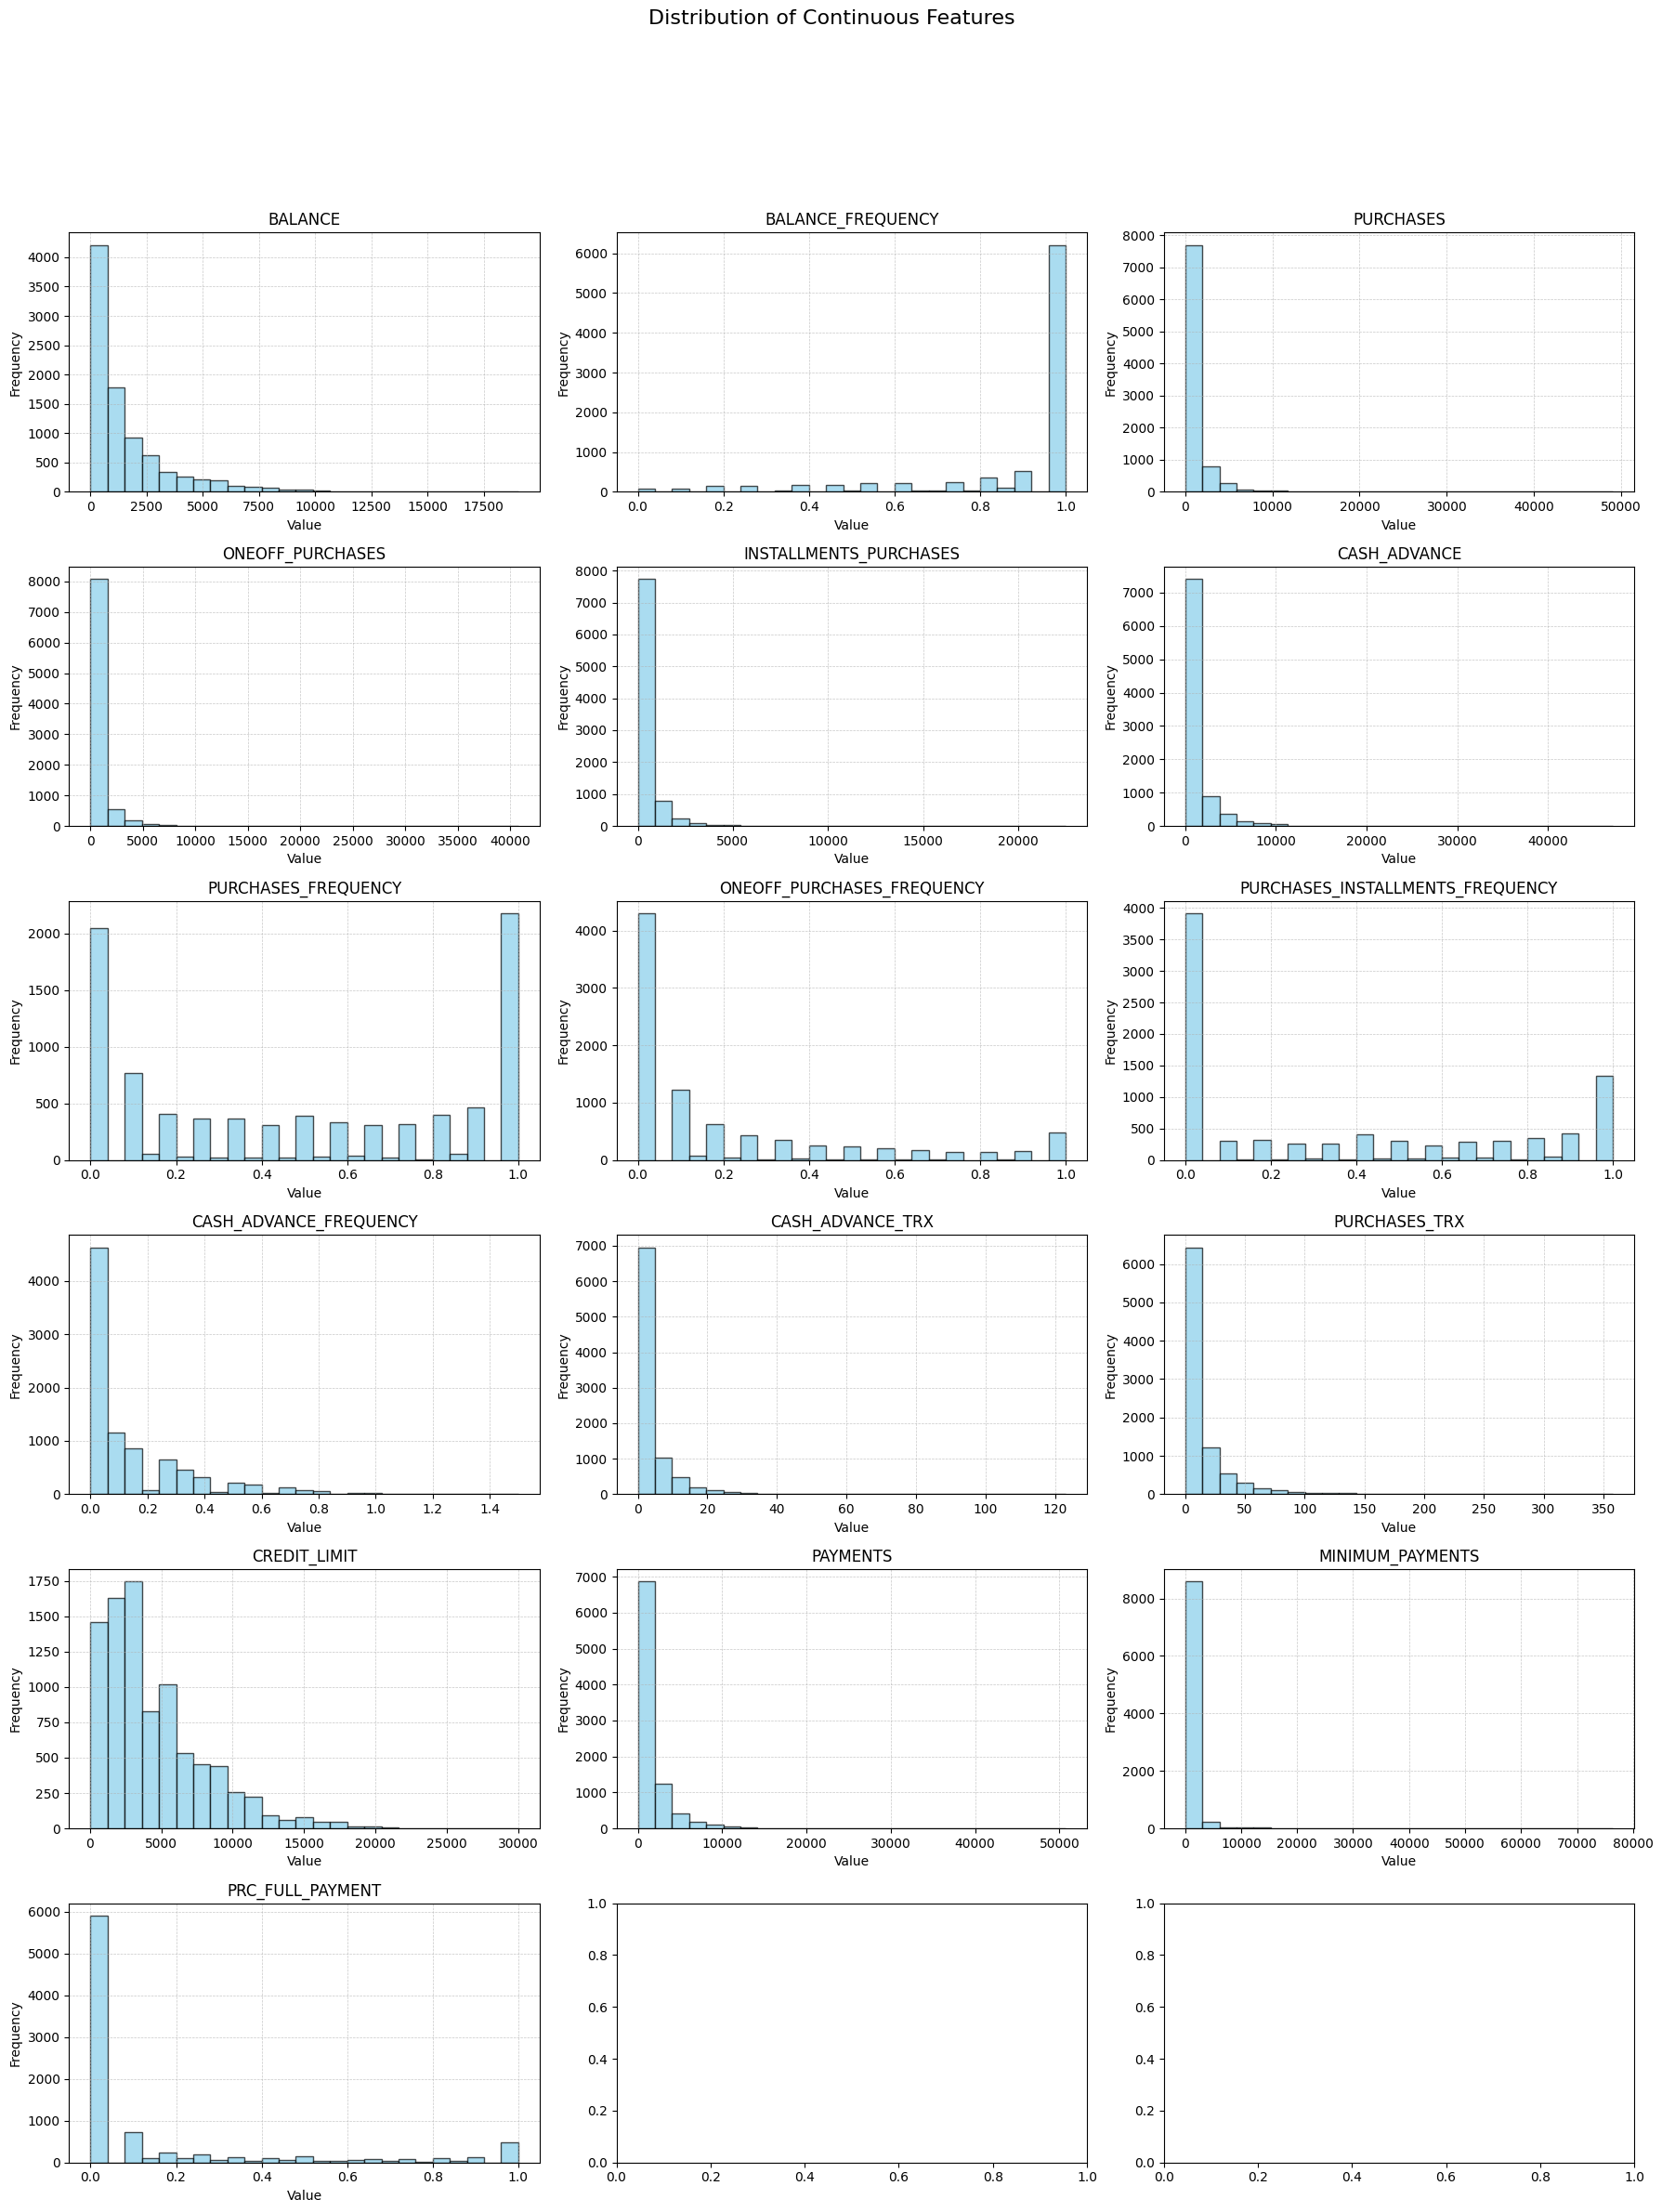

In [106]:
# Histograms for Continuous Variables
continuous_columns = [
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
    'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
    'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
    'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'
]

# Set up the figure with a customized size
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 24))
fig.suptitle('Distribution of Continuous Features', fontsize=16, y=1.02)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through each column and plot on individual subplots
for idx, column in enumerate(continuous_columns):
    axes[idx].hist(data[column].dropna(), bins=25, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(column, fontsize=12)
    axes[idx].set_xlabel('Value', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Findings:
- Highly Skewed Distributions: Many features, such as "BALANCE," "PURCHASES," and "PAYMENTS," exhibit a right-skewed distribution, indicating that most customers have relatively low values for these metrics, with only a few having significantly higher values.

- Frequency-based Features: Columns like "BALANCE_FREQUENCY" and "PRC_FULL_PAYMENT" show limited variation, suggesting that most customers either frequently maintain their balances or consistently pay in full, respectively.

- Sparse High-Value Data: Features such as "CREDIT_LIMIT" and "MINIMUM_PAYMENTS" reveal sparse data for high values, showing a concentration of low to moderate values, with only a small proportion of customers in the high range.

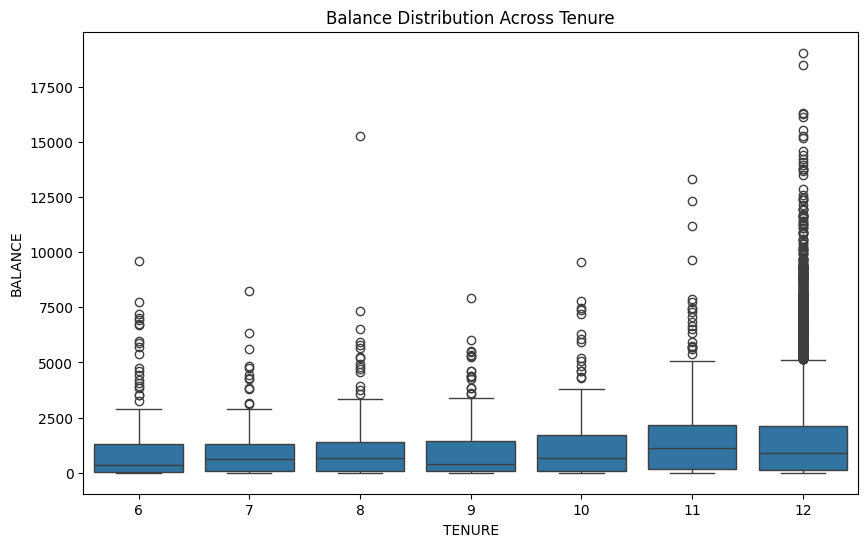

In [107]:
# Box plot for Balance distribution across tenure
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='TENURE', y='BALANCE')
plt.title("Balance Distribution Across Tenure")
plt.show()

Findings:
- The box plot indicates that customers with a longer tenure (e.g., 12 months) tend to have a wider range of balances, with several high-balance outliers.
- This could suggest that longer-tenured customers vary more in their financial behaviors or balance patterns, possibly due to differing customer needs or levels of financial engagement.

Outlier Detection Using Box Plots:
- Visualize outliers in key features like “BALANCE” and “PURCHASES” to understand customer spending patterns.

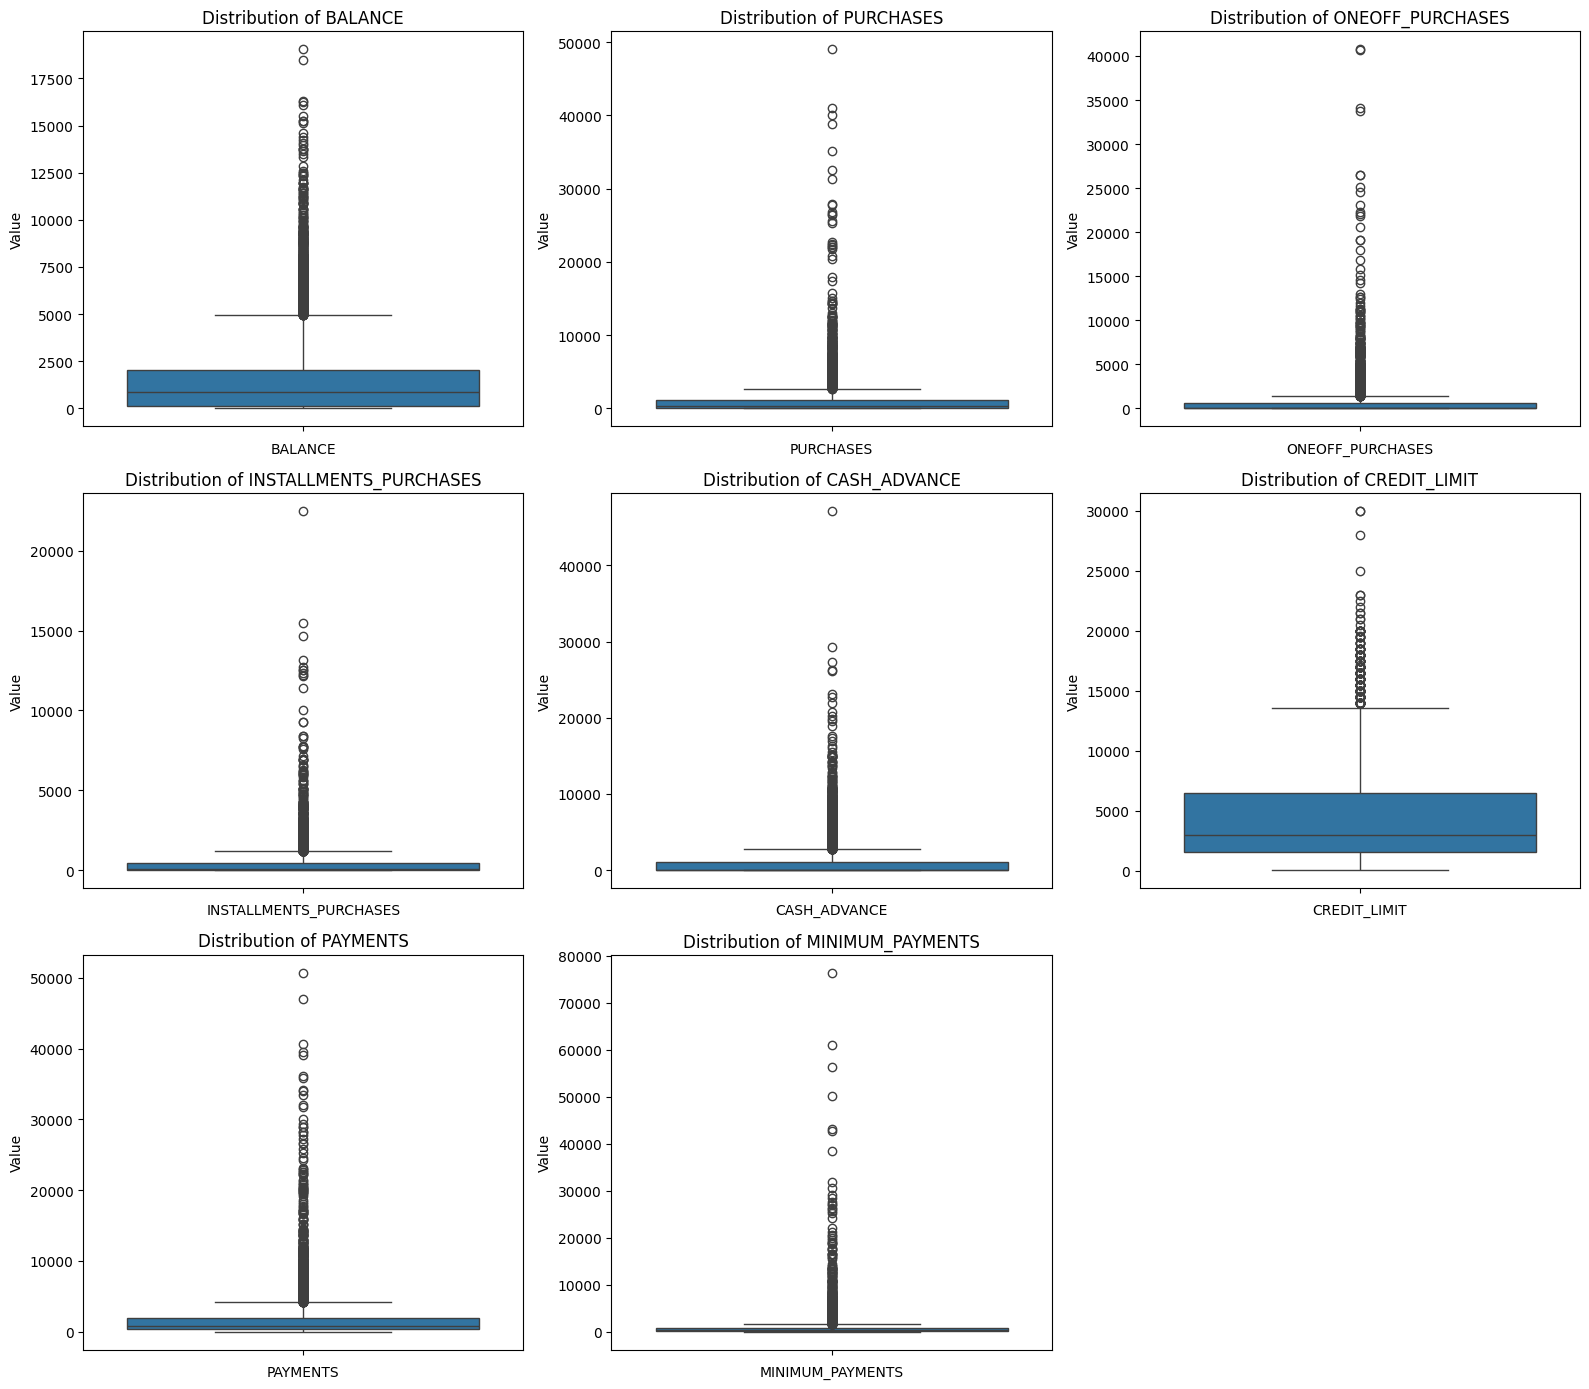

In [ ]:
# Outlier Analysis with Box Plots
# Creating box plots for numerical fields to identify potential outliers

# List of columns to examine for outliers
monetary_columns = [
    'BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 
    'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS'
]

# Set up the plot dimensions for displaying multiple box plots
plt.figure(figsize=(16, 14))

# Generate box plots for each column in the list to observe value distributions
for idx, col in enumerate(monetary_columns, start=1):
    plt.subplot(3, 3, idx)
    sns.boxplot(data=data[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Findings:
- Presence of Outliers: Almost all the monetary fields (e.g., BALANCE, PURCHASES, CASH_ADVANCE, PAYMENTS) show a significant number of high-value outliers, as indicated by points far above the upper whisker in each box plot.

- Potential Impact on Clustering: These outliers could heavily influence clustering algorithms, especially K-Means, by skewing cluster centroids towards the high-value outliers. Removing or managing these values could improve clustering performance.

- Variation Across Features: Some features, such as CREDIT_LIMIT, show a broader interquartile range compared to others, indicating more inherent variation in values among customers, whereas features like BALANCE_FREQUENCY have relatively consistent values with fewer extreme outliers.

Histogram and Density Plots:
- Check the distribution of numeric features like “BALANCE,” “CREDIT_LIMIT,” “PAYMENTS,” etc., to identify skewness or multi-modal distributions.

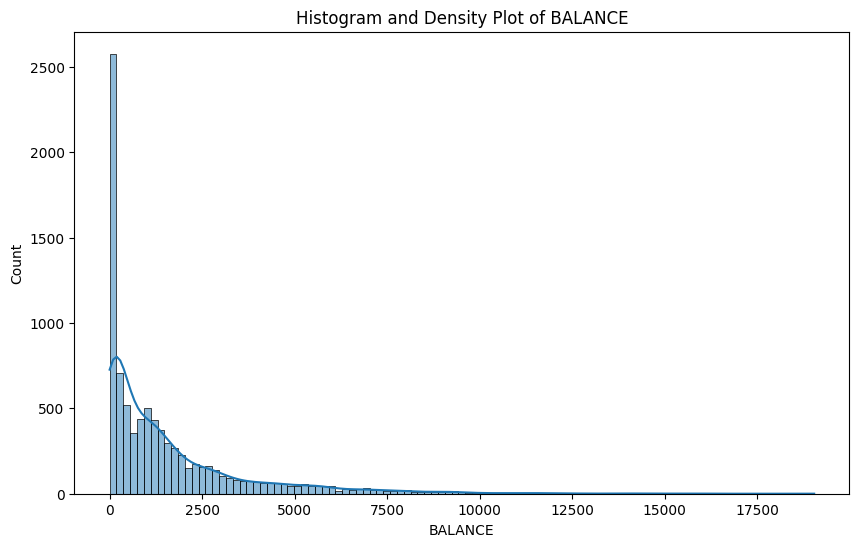

In [109]:
# Histogram and density plot for BALANCE
plt.figure(figsize=(10, 6))
sns.histplot(data['BALANCE'], kde=True)
plt.title("Histogram and Density Plot of BALANCE")
plt.show()

Findings:
- The “BALANCE” feature has a highly skewed distribution, with most values concentrated on the lower end and a long tail of higher balances.
- Skewness in balance distribution may affect clustering, so applying a log transformation to balance values could help normalize the data and improve clustering results.

In order to enhance the dataset, we consider to apply these before clustering:

1. Feature Engineering: Create new features or ratios based on existing ones, such as a “PURCHASES_TO_CREDIT_LIMIT_RATIO” to capture spending behavior relative to credit limits.


In [110]:
# Adding a feature: Ratio of purchases to credit limit (to understand spending behavior)
data['PURCHASES_TO_CREDIT_LIMIT_RATIO'] = data['PURCHASES'] / data['CREDIT_LIMIT']

# Adding a feature: Ratio of payments to balance (to understand repayment behavior)
data['PAYMENTS_TO_BALANCE_RATIO'] = data['PAYMENTS'] / data['BALANCE']

# Adding a feature: Total number of transactions (purchases + cash advances)
data['TOTAL_TRANSACTIONS'] = data['PURCHASES_TRX'] + data['CASH_ADVANCE_TRX']

# Fill any NaN values created by these operations (e.g., divide by zero) with 0
data.fillna(0, inplace=True)

2. Log Transformation: Apply log transformations to highly skewed features like “BALANCE” to address the skewness and reduce the impact of outliers.

In [111]:
# Apply log transformation to highly skewed features
# Adding 1 to avoid log(0) issues
data['BALANCE_LOG'] = np.log1p(data['BALANCE'])
data['PURCHASES_LOG'] = np.log1p(data['PURCHASES'])
data['CASH_ADVANCE_LOG'] = np.log1p(data['CASH_ADVANCE'])
data['PAYMENTS_LOG'] = np.log1p(data['PAYMENTS'])
data['CREDIT_LIMIT_LOG'] = np.log1p(data['CREDIT_LIMIT'])

3. Outlier Processing: Remove severe outliers based on transformed features.

In [112]:
# Define a function to remove severe outliers using the IQR method
def remove_outliers(data, columns, threshold = 1.5):
    # Loop through each specified column
    for column in columns:
        # Calculate the IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        # Filter the DataFrame to exclude outliers
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return data

In [113]:
# List of columns to check for severe outliers (using transformed columns)
columns_to_check = ['BALANCE_LOG', 'PURCHASES_LOG', 'CASH_ADVANCE_LOG', 'PAYMENTS_LOG', 'CREDIT_LIMIT_LOG']

In [114]:
# Apply the function to remove severe outliers in specified columns
df = remove_outliers(data, columns_to_check)

In [115]:
# Print the shape of the dataset before and after outlier removal
print("Original data shape:", data.shape)
print("Data shape after removing severe outliers:", df.shape)

Original data shape: (8950, 25)
Data shape after removing severe outliers: (8538, 25)


Correlation Analysis (Pairplot and Heatmap):
- Identify relationships between numeric features.

- Highlight any highly correlated features which could impact clustering.

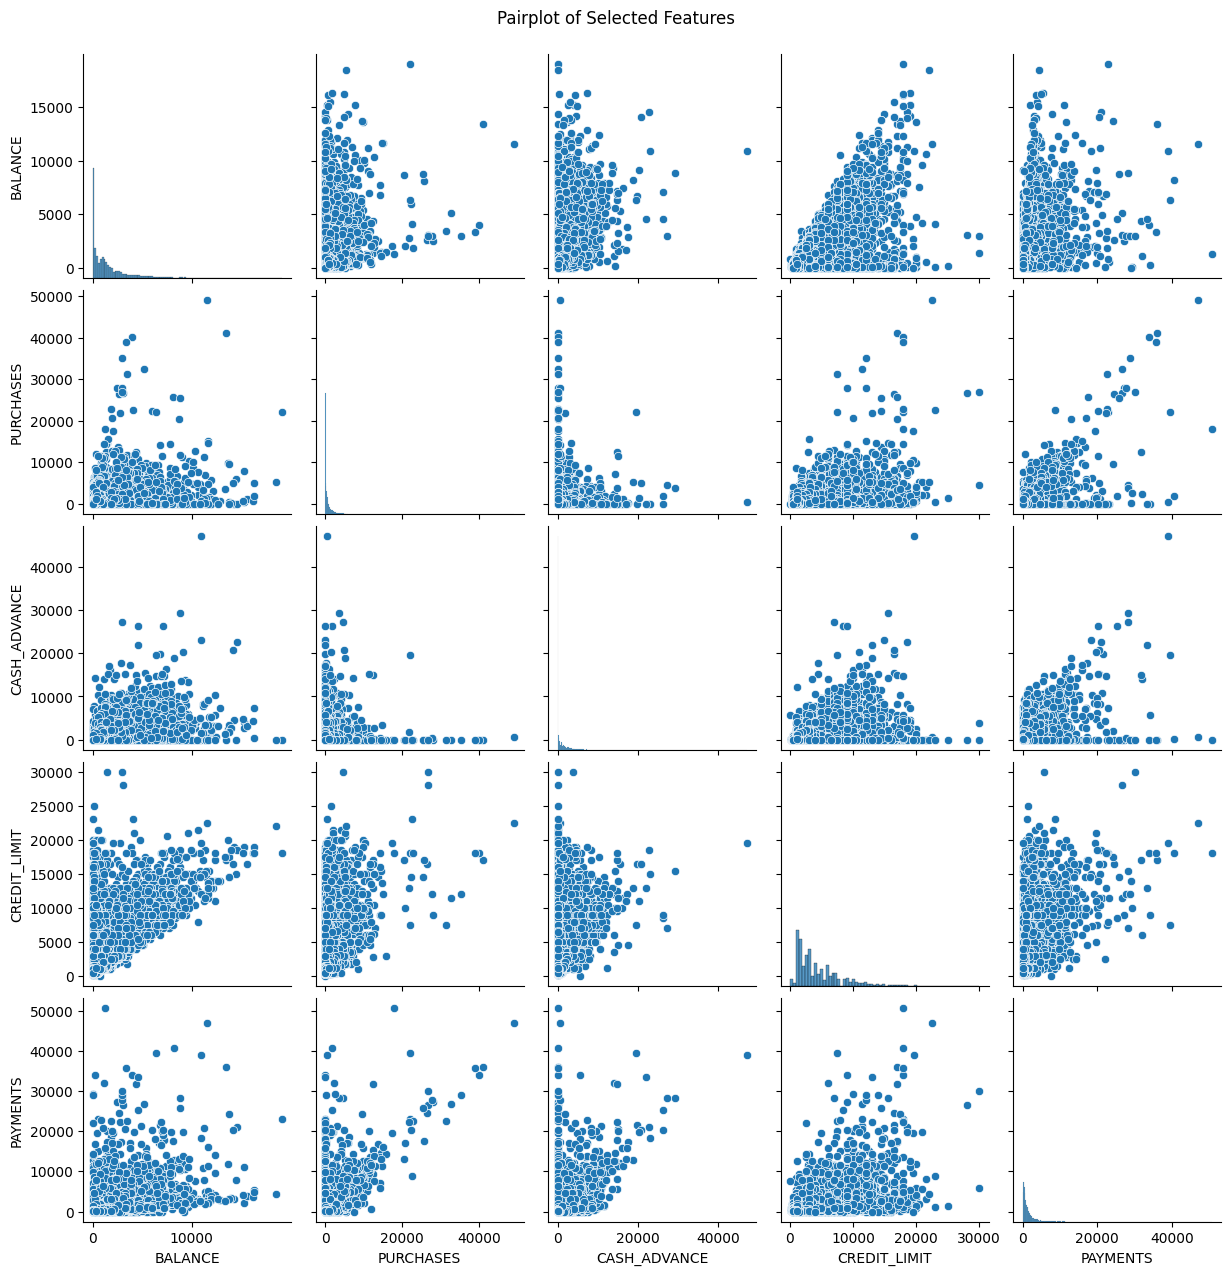

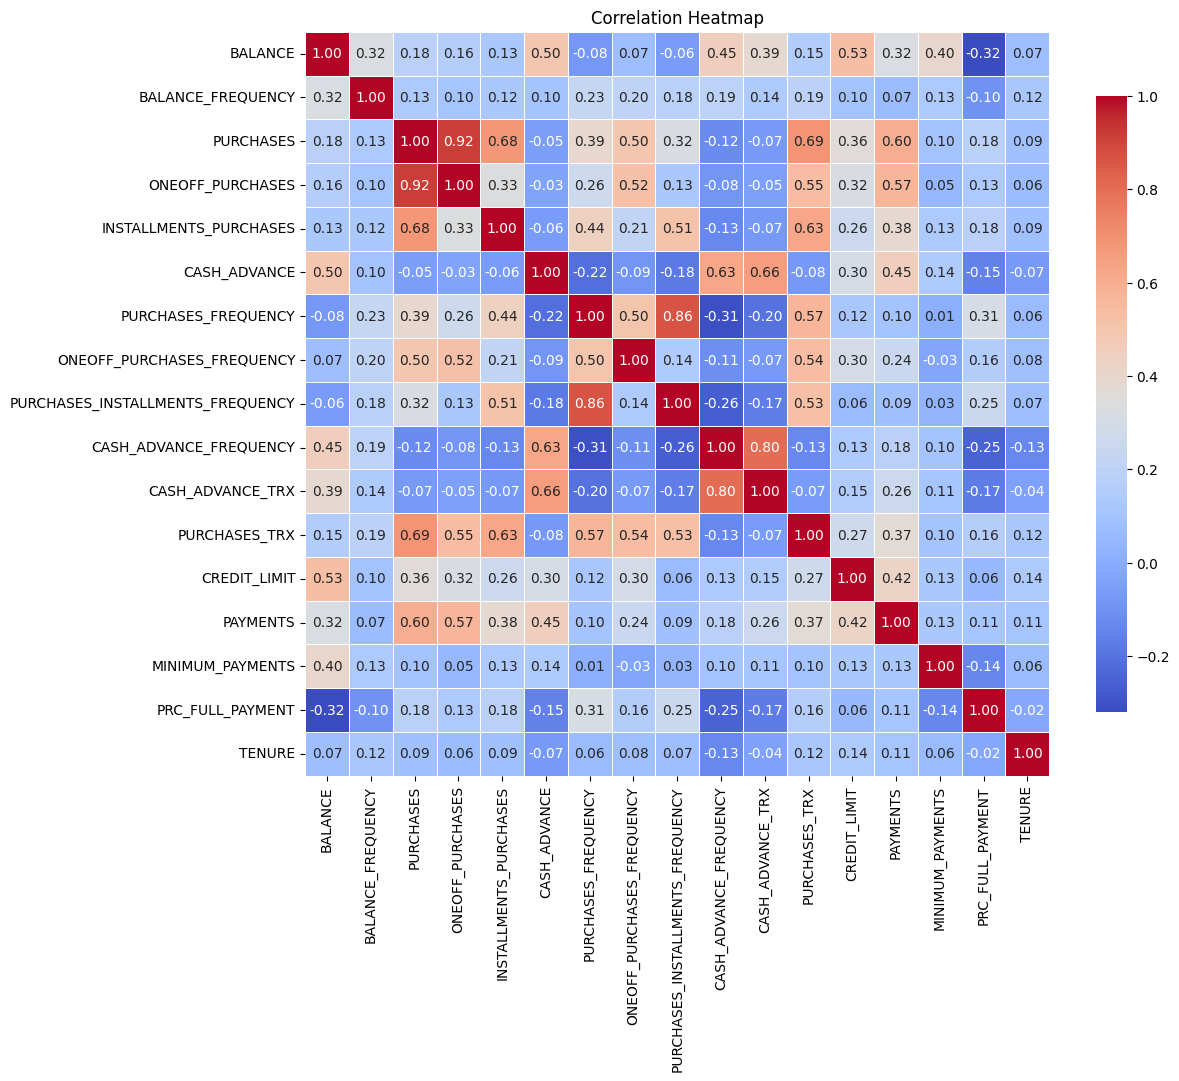

In [116]:
# Pairplot for selected features
sns.pairplot(data[['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']])
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# Correlation Heatmap
columns_to_plot = [
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
    'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
    'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
    'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
    'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
    'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'
]

correlation_matrix = data[columns_to_plot].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True,    
    fmt=".2f",     
    cmap='coolwarm', 
    linewidths=0.7, 
    square=True,   
    cbar_kws={"shrink": 0.8}  
)

plt.title('Correlation Heatmap')
plt.show()

Findings:

Pair Plot Analysis:

- Visual inspection shows some clusters and relationships between specific features. For example, high values in PURCHASES often correspond with high CREDIT_LIMIT and PAYMENTS.
- The spread in BALANCE and CASH_ADVANCE suggests varied behavior in these features, with a dense cluster of lower values and a sparse distribution in the higher ranges.
- Most features display a skewed distribution, indicating potential outliers and skewed customer behavior in terms of financial transactions.

Correlation Heatmap Analysis:

- Strong Positive Correlations:
PURCHASES shows a strong correlation with INSTALLMENTS_PURCHASES (0.68) and PAYMENTS (0.60), suggesting that higher purchases may lead to higher payments and installment-based purchases.
- CREDIT_LIMIT has a notable correlation with BALANCE (0.53), indicating that customers with higher credit limits often have higher balances.
- Moderate to High Correlations:
PURCHASES_FREQUENCY and PURCHASES_TRX have a strong relationship (0.70), suggesting a link between the frequency and volume of purchases.
CASH_ADVANCE and CASH_ADVANCE_TRX also correlate (0.61), which makes sense as higher transactions would increase the overall cash advance amount.
- Implication for Feature Selection:
The high correlations between certain features may allow for dimensionality reduction, where highly correlated variables could be consolidated or transformed to reduce redundancy and improve clustering efficiency.

Specifically from the correlation heatmap: 
We identified 16 pairs of features with moderate to high correlations (correlation coefficient > 0.7), suggesting potential redundancy. High correlations between features can introduce noise into clustering, so it’s beneficial to reduce redundancy by carefully selecting features. Here’s a breakdown of correlated pairs:

- Purchases:

Strongly correlated with Oneoff_Purchases (0.75) and Installments_Purchases (0.67).
Shows moderate correlations with Purchases_Frequency (0.60), Oneoff_Purchases_Frequency (0.55), and Purchases_TRX (0.67).

- Oneoff_Purchases:

Correlates significantly with Oneoff_Purchases_Frequency (0.71), indicating frequency-driven purchase behavior.

- Installments_Purchases:

Displays correlations with Purchase_Frequency (0.62), Purchase_Installments_Frequency (0.7), and Purchases_TRX (0.60), reflecting a link between purchase frequency and installments.

- Cash_Advance:

Correlates with Cash_Advance_Frequency (0.62) and Cash_Advance_TRX (0.61).
Shows a moderate link to Payments (0.52), which may indicate reliance on cash advances for certain customer segments.

- Purchases_Frequency:

Highly correlated with Purchases_Installments_Frequency (0.87) and Purchases_TRX (0.7), showing that transaction frequency strongly influences the overall purchase activity.

- Purchase_TRX:

Has a noticeable correlation with Purchase_Installments_Frequency (0.62), suggesting that installment behavior is aligned with transaction volume.

- Cash_Advance_TRX:

Strongly correlated with Cash_Advance_Frequency (0.79), linking transaction count to cash advance usage patterns.


In [117]:
# Find out which features have high correlations
threshold = 0.6
high_corr_pairs =[]

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i,j]
            high_corr_pairs.append((feature1, feature2, correlation_value))

print(high_corr_pairs)

[('ONEOFF_PURCHASES', 'PURCHASES', 0.9168445587151489), ('INSTALLMENTS_PURCHASES', 'PURCHASES', 0.6798962203562023), ('PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY', 0.8629336372699634), ('CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE', 0.6285220743115754), ('CASH_ADVANCE_TRX', 'CASH_ADVANCE', 0.656497541680611), ('CASH_ADVANCE_TRX', 'CASH_ADVANCE_FREQUENCY', 0.7995607573993837), ('PURCHASES_TRX', 'PURCHASES', 0.6895608345245253), ('PURCHASES_TRX', 'INSTALLMENTS_PURCHASES', 0.6281075383558642), ('PAYMENTS', 'PURCHASES', 0.6032638314010599)]


Here: 
- Removed Features: 
Based on the high correlation pairs you identified, we’ve removed PURCHASES, INSTALLMENTS_PURCHASES, PURCHASES_FREQUENCY, CASH_ADVANCE, PURCHASES_TRX, and PAYMENTS, as they are strongly correlated with other features retained in the list.

- Retained Features: The selected features focus on capturing various aspects of customer behavior without redundancy:

~TENURE: Indicates account length, with no high correlation.

~BALANCE and BALANCE_FREQUENCY: Capture balance and its consistency over time.

~ONEOFF_PURCHASES_FREQUENCY and CASH_ADVANCE_FREQUENCY: Reflect individual spending patterns without overlapping with total values.

~CREDIT_LIMIT and PRC_FULL_PAYMENT: Relate to credit availability and payment practices.

These features were selected for their relevance to customer behavior and financial profile, while avoiding redundant information from highly correlated features:

- TENURE:

Provides insight into the length of the customer relationship.
Helps in understanding customer loyalty and retention trends, as longer tenure often indicates a stable customer.

- ONEOFF_PURCHASES_FREQUENCY:

Reflects the frequency of one-off (non-recurring) purchases.
This feature is valuable for distinguishing between customers who make frequent impulsive or infrequent high-value purchases.
CASH_ADVANCE_FREQUENCY:

Indicates how often a customer takes cash advances.
Useful for segmenting customers based on their need for liquidity, which could imply different risk levels or spending behaviors.

- BALANCE:

Represents the overall account balance, indicating customer spending patterns.
Essential for understanding the financial health of the customer and identifying high-balance accounts.

- PURCHASES:

Shows total purchase amount, providing a measure of spending activity.
Important for profiling customers based on their spending behavior and potential value to the business.

- CREDIT_LIMIT:

Indicates the maximum amount the customer is allowed to borrow.
Helps in assessing the financial standing and creditworthiness of the customer, which can be key for segmentation.

- PAYMENTS:

Represents total payments made, offering insight into the customer’s repayment behavior.
Crucial for identifying customers who consistently make large payments versus those who do not, impacting customer lifetime value and risk.

In [118]:
# Data Preprocessing (Scaling)
features = ['TENURE', 'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 
            'BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']
X = df[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Part 3: Clustering Algorithms
-

- Implement at least three different clustering algorithms of your choice (e.g., K-Means, Hierarchical, DBSCAN). You can try any algorithms available in sklearn.
- Use Elbow method, Silhouette analysis, or other techniques to determine the optimal number of clusters.
Discuss each method, and select the most appropriate.

1. K-Means Clustering

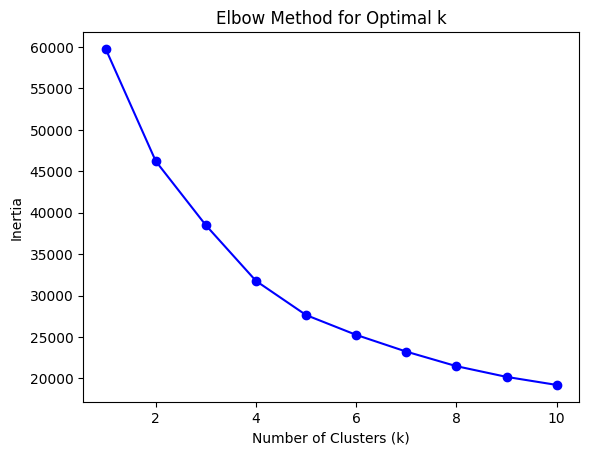

In [119]:
# Elbow Method with KMeans to find optimal k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


Silhouette Score for K-Means: 0.392


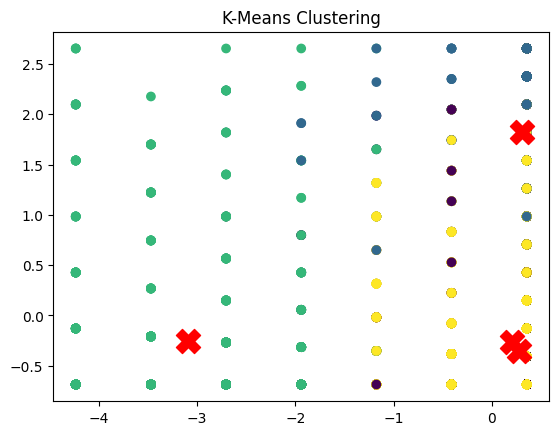

In [120]:
# Apply K-Means with optimal k (e.g., k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Silhouette Analysis for K-Means
sil_score_kmeans = silhouette_score(X_scaled, labels_kmeans)
print(f'Silhouette Score for K-Means: {sil_score_kmeans:.3f}')

# Visualize K-Means clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title('K-Means Clustering')
plt.show()

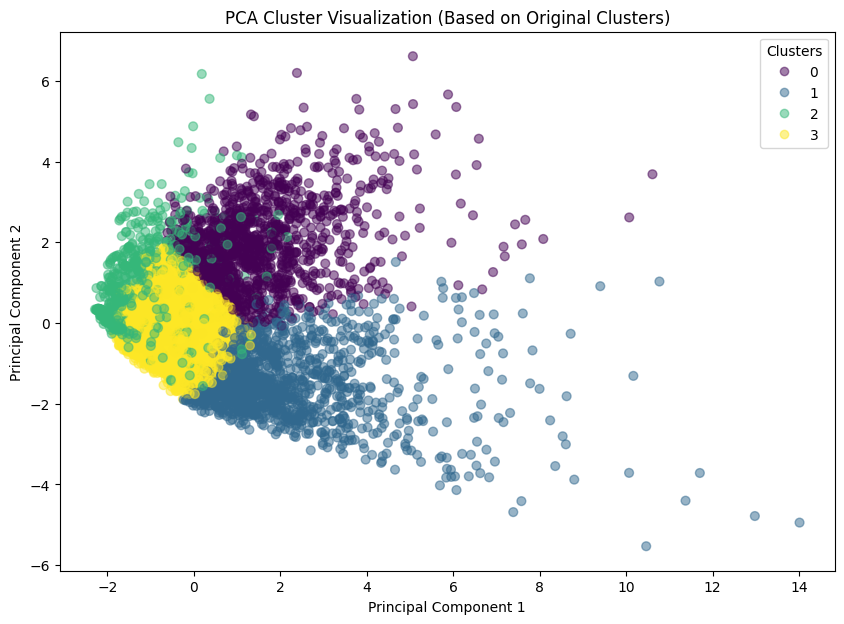

In [121]:
# Fit PCA on the original scaled data for visualization 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)  # Replace X_scaled with your standardized data variable

# Create a DataFrame with PCA components for easy handling in visualization
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels_kmeans  # Assuming 'labels_kmeans' is the clustering result from K-Means

# Plot the clusters in the reduced 2D PCA space
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.5, s=40)
plt.title("PCA Cluster Visualization (Based on Original Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

Findings of K-Means Clustering:

- The Elbow Method (as shown in the plot) suggests that the optimal number of clusters is 4. Cluster Structure: With k=4, K-Means captures some general groupings within the data, but the moderate score suggests possible overlap or noise within clusters.

- Moderate Silhouette Score: The silhouette score for K-Means clustering is 0.392, indicating that the clusters are moderately well-separated but could benefit from improvement.

- Cluster Shape Limitation: Since K-Means assumes spherical clusters, it may not fully capture complex or elongated clusters in the data, potentially leading to less distinct segmentation.

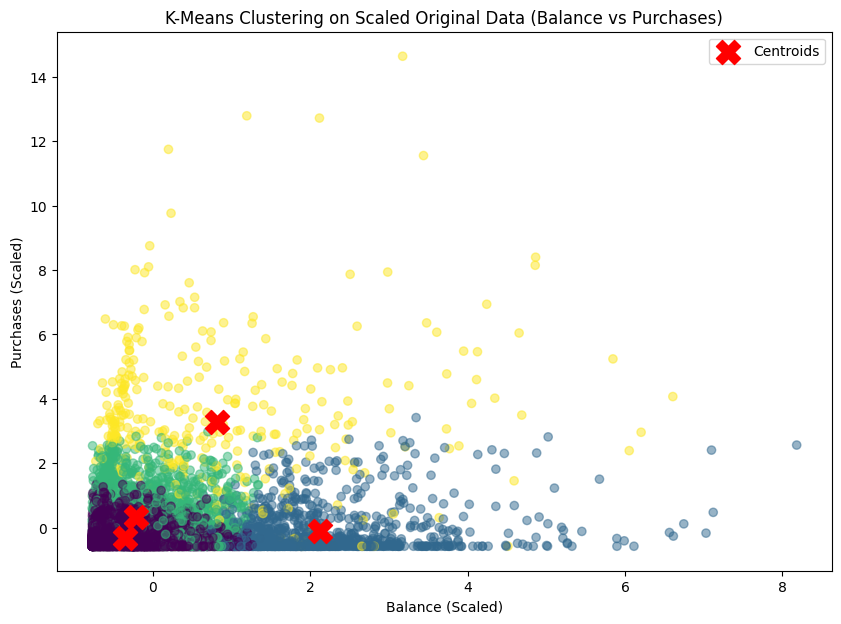

Silhouette Score for K-Means (Scaled Original Data): 0.396


In [122]:
# Step 1: Ensure the DataFrame reference is correct
X_original = df[['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']].dropna()

# Step 2: Standardize the selected features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_original_scaled = scaler.fit_transform(X_original)

# Step 3: Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
labels_original = kmeans.fit_predict(X_original_scaled)

# Step 4: Add cluster labels to the DataFrame for interpretation
df.loc[X_original.index, 'Cluster_Original'] = labels_original

# Step 5: Visualize the clusters (using only two features for plotting)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(X_original_scaled[:, 0], X_original_scaled[:, 1], c=labels_original, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering on Scaled Original Data (Balance vs Purchases)')
plt.xlabel('Balance (Scaled)')
plt.ylabel('Purchases (Scaled)')
plt.legend()
plt.show()

# Step 6: Calculate the Silhouette Score
from sklearn.metrics import silhouette_score
sil_score_original = silhouette_score(X_original_scaled, labels_original)
print(f'Silhouette Score for K-Means (Scaled Original Data): {sil_score_original:.3f}')

2. Hierarchical Clustering

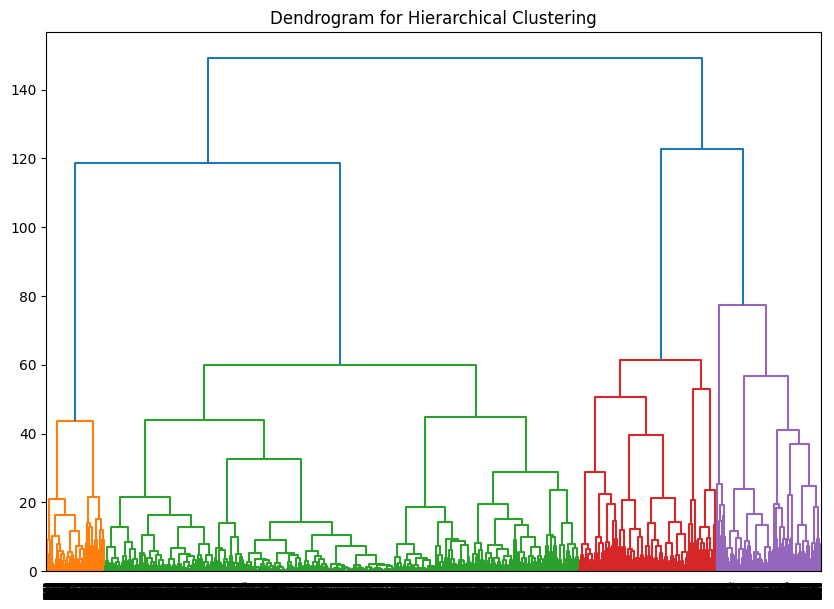

Silhouette Score for Hierarchical: 0.347


In [123]:
# Hierarchical Clustering with Dendrogram
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

# Apply Agglomerative Clustering with Hierarchical method
hier_cluster = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_hier = hier_cluster.fit_predict(X_scaled)

# Silhouette Analysis for Hierarchical
sil_score_hier = silhouette_score(X_scaled, labels_hier)
print(f'Silhouette Score for Hierarchical: {sil_score_hier:.3f}')

Findings of Hierarchical Clustering:

- Silhouette Score: The silhouette score for hierarchical clustering with ward linkage is 0.347. This score suggests a moderate level of cluster separation, slightly lower than K-Means, indicating that the clusters may overlap somewhat.

- Dendrogram Insights: The dendrogram provides a visual representation of the hierarchical structure in the data. It shows that some clusters merge at relatively low distances, while others join at higher levels, indicating a range of cluster densities and potential sub-clusters.

- Cluster Structure: Using ward linkage tends to create compact, spherical clusters, similar to K-Means. This linkage criterion minimizes variance within each cluster, which may result in clusters that are more compact but may not perfectly capture elongated or irregular shapes in the data.

3. DBSCAN Clustering

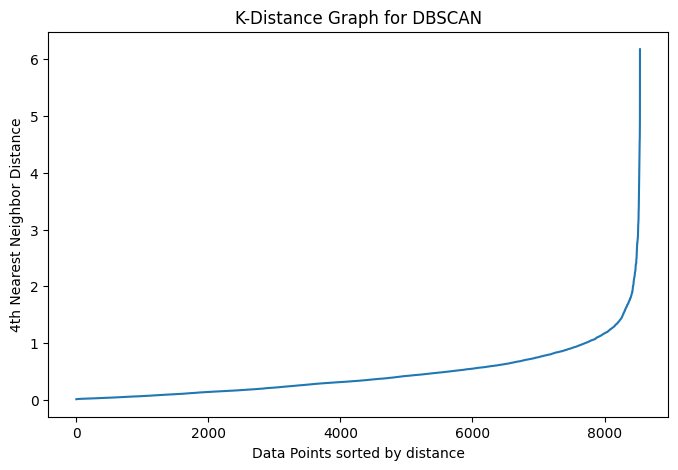

In [124]:
# DBSCAN Clustering with tuned parameters (eps and min_samples)
# Use K-Distance plot to find optimal 'eps' value
neighbors = NearestNeighbors(n_neighbors=4)  # 4th nearest neighbor for density estimation
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to find the elbow point in K-Distance Graph
distances = np.sort(distances[:, 3], axis=0)  # Sort by the 4th nearest neighbor distance
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()

In [ ]:
# Apply DBSCAN with selected 'eps' value from the K-Distance Graph
dbscan = DBSCAN(eps=1.0, min_samples=3)  # Adjust 'eps' based on the K-Distance Graph
labels_dbscan = dbscan.fit_predict(X_scaled)

# Count noise points in DBSCAN (labeled as -1)
n_noise = list(labels_dbscan).count(-1)
print(f'Number of Noise Points in DBSCAN: {n_noise}')

Number of Noise Points in DBSCAN: 501


Silhouette Score for DBSCAN: 0.120


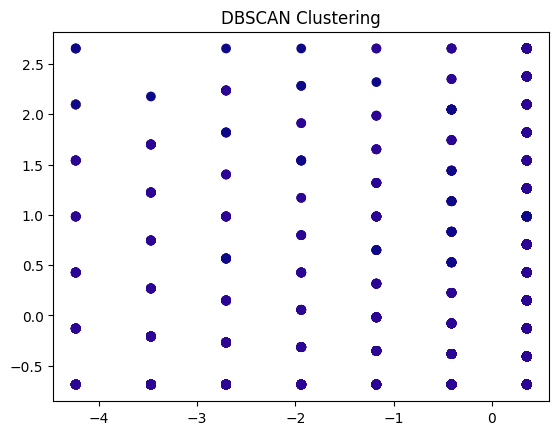

In [126]:
# Silhouette Score Calculation for DBSCAN, excluding noise points
core_samples_mask = labels_dbscan != -1  # Exclude noise points for silhouette calculation
if len(set(labels_dbscan)) > 1:
    silhouette_avg_dbscan = silhouette_score(X_scaled[core_samples_mask], labels_dbscan[core_samples_mask])
    print(f'Silhouette Score for DBSCAN: {silhouette_avg_dbscan:.3f}')
else:
    print("DBSCAN did not find any clusters other than noise.")

# Visualize DBSCAN clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan, cmap='plasma', marker='o')
plt.title('DBSCAN Clustering')
plt.show()

Findings of DBSCAN Clustering:

- K-Distance Graph Insights: The K-Distance graph shows a steep increase around a 4th nearest neighbor distance of approximately 1.0, indicating a potential choice for the eps parameter. However, the clustering results suggest this value might still be too low for capturing meaningful clusters.

- High Number of Noise Points: With eps=1.0 and min_samples=3, DBSCAN identified 501 noise points, meaning a large portion of the data was not assigned to any cluster. This high number of noise points often indicates that the chosen parameters may not effectively capture the cluster density.

- Low Silhouette Score: The silhouette score for DBSCAN clustering is 0.120, indicating poorly separated clusters. This low score suggests that the clusters are either overlapping significantly or that the clustering structure is weak under the current parameter settings.

4. Mean Shift Clustering

- Mean Shift is a centroid-based algorithm that seeks dense areas of data points and iteratively shifts the centroid towards the mean of the points within a given bandwidth. It does not require specifying the number of clusters.

- Suitable for datasets where the number of clusters is unknown, and there are dense regions that could represent clusters.

Silhouette Score for Mean Shift: 0.303


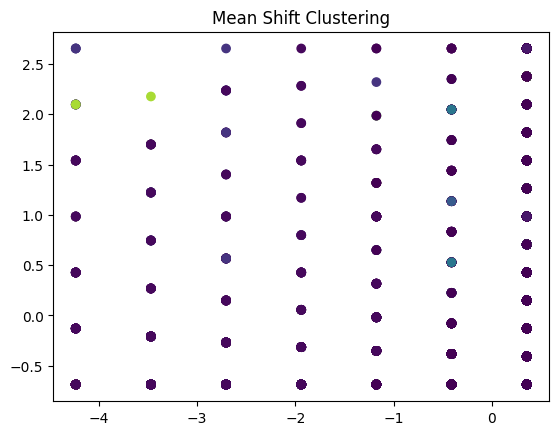

In [ ]:
# Estimate bandwidth (radius of neighborhood for clustering) based on data
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)

# Mean Shift clustering
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_mean_shift = mean_shift.fit_predict(X_scaled)

# Silhouette Score for Mean Shift
sil_score_mean_shift = silhouette_score(X_scaled, labels_mean_shift)
print(f'Silhouette Score for Mean Shift: {sil_score_mean_shift:.3f}')

# Visualization
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_mean_shift, cmap='viridis', marker='o')
plt.title('Mean Shift Clustering')
plt.show()

Findings:
- Moderate Silhouette Score: The silhouette score for Mean Shift clustering is 0.303, indicating a moderate level of cluster separation. This score suggests that the clusters are not well-defined and may overlap or contain noise.

- Bandwidth Selection: The bandwidth parameter, estimated using the quantile-based method, influences the clustering outcome significantly. Although it defines neighborhood size, the resulting clusters appear sparse, which may indicate that the selected bandwidth could be either too small or that the data does not naturally form dense clusters.

- Sparse Clustering Structure: The resulting plot shows only a few distinct colors, indicating that Mean Shift either clustered most points into a single cluster or formed many small, indistinct clusters. This could suggest that Mean Shift may not be an ideal algorithm for this dataset, as it may not capture meaningful patterns.

Part 4: Interpreting Clusters
-

Characterize the clusters formed: What kind of customers fall into each cluster? What features are most significant in distinguishing between clusters?

In [128]:
# Define the data for the comparison table
data = {
    "Algorithm": ["K-Means", "Hierarchical Clustering", "DBSCAN", "Mean Shift"],
    "Silhouette Score": [0.392, 0.347, 0.120, 0.303],
    "Number of Clusters": ["4", "4", "1 (plus noise)", "Sparse Clusters"],
    "Key Observations": [
        "Clear and interpretable clusters with distinct customer segments based on tenure, purchase frequency, and cash advance usage.",
        "Similar cluster structure to K-Means but slightly lower silhouette score, indicating potential overlaps.",
        "Most points marked as noise, yielding poor separation and interpretability.",
        "Formed small, scattered clusters, resulting in poor separation and interpretability."
    ]
}

# Create a DataFrame
comparison_table = pd.DataFrame(data)

# Display the table
print(comparison_table)

                 Algorithm  Silhouette Score Number of Clusters  \
0                  K-Means             0.392                  4   
1  Hierarchical Clustering             0.347                  4   
2                   DBSCAN             0.120     1 (plus noise)   
3               Mean Shift             0.303    Sparse Clusters   

                                    Key Observations  
0  Clear and interpretable clusters with distinct...  
1  Similar cluster structure to K-Means but sligh...  
2  Most points marked as noise, yielding poor sep...  
3  Formed small, scattered clusters, resulting in...  


Based on the clustering results across the four algorithms (K-Means, Hierarchical, DBSCAN, and Mean Shift), K-Means provides the most interpretable and distinct clusters, as evidenced by the highest silhouette score (0.392) compared to the others. Here’s a characterization of the K-Means clusters formed:


- Cluster 0:

Average Tenure: 11.72 years
One-Off Purchases Frequency: Moderate (0.12)
Cash Advance Frequency: Low
Interpretation: This cluster likely represents long-standing customers with low cash advance usage and occasional one-off purchases. They may be more stable, conservative customers.

- Cluster 1:

Average Tenure: 11.77 years
One-Off Purchases Frequency: Low (0.07)
Cash Advance Frequency: Low
Interpretation: These customers have been with the organization for a long time but have very low purchase and cash advance activity. They may represent inactive or low-engagement customers.

- Cluster 2:

Average Tenure: 11.87 years
One-Off Purchases Frequency: High (0.54)
Cash Advance Frequency: High
Interpretation: This group consists of long-term customers with high one-off purchases and high cash advance usage, possibly indicating a segment that is financially active and might use credit services more frequently.

- Cluster 3:

Average Tenure: 11.89 years
One-Off Purchases Frequency: Very Low (0.06)
Cash Advance Frequency: Low
Interpretation: These are long-standing customers with low overall transaction frequency, indicating they may not be highly engaged or financially active within the system.

- Cluster 4:

Average Tenure: 7.37 years
One-Off Purchases Frequency: Moderate (0.10)
Cash Advance Frequency: Very Low
Interpretation: This group has a lower average tenure, suggesting newer customers with moderate one-off purchases but very low cash advance usage. They may represent a newer, potentially growing segment of customers.


Recommendation for Clustering Choice:

Comparison and Recommendation
K-Means achieved the highest silhouette score (0.392), indicating the best-defined clusters with meaningful segment distinctions. These clusters align with intuitive interpretations based on customer behavior and tenure, making K-Means the most suitable algorithm for this dataset.

Hierarchical Clustering provided a similar structure to K-Means but with a slightly lower silhouette score (0.347). While it could be a backup option, its performance was marginally weaker, suggesting that K-Means captures the data structure slightly better.

DBSCAN and Mean Shift did not yield meaningful clusters. DBSCAN marked a majority of points as noise, resulting in poor interpretability. Mean Shift formed scattered, indistinct clusters with a low silhouette score, making it less suitable for this dataset.

Given the comparative performance, K-Means is the recommended clustering algorithm for this dataset due to its clearer segmentation and higher silhouette score. Hierarchical clustering provides a slightly lower silhouette score but could be a backup option if needed. DBSCAN and Mean Shift did not produce meaningful clusters in this case, as shown by their low silhouette scores and high noise points, respectively.

Summary:

Using four clustering algorithms was insightful for exploring different clustering structures, but in this case, only K-Means provided clearly interpretable and distinct clusters. The additional algorithms helped validate the choice of K-Means by demonstrating that other methods did not yield substantial improvements. Hence, it may not be necessary to rely on multiple clustering algorithms if K-Means alone captures the cluster characteristics adequately.

Using multiple clustering algorithms helped validate the choice of K-Means by demonstrating that other methods did not yield better-defined or more interpretable clusters. Therefore, K-Means is the recommended clustering algorithm for this dataset due to its clear segmentation, higher silhouette score, and ease of interpretation based on original customer behavior attributes.

Part 5: Actionable Insights
-

Provide business recommendations based on the clusters formed. How would you target different customer segments?

Based on the characteristics of each K-Means cluster, here are targeted recommendations for engaging different customer segments:

- Cluster 0: Long-tenured, Moderate-Spending Customers

    - Spending Customers Engagement Strategy: Encourage higher spending through loyalty programs. Since they are long-tenured, reward their loyalty with exclusive offers. 

    - Product Recommendations: Promote value-added services (like personal finance management or investment advice) that might interest stable customers. Cross-selling: Offer them products with low-risk returns, as they likely prefer conservative financial choices. 

    - Promotions: Use limited-time discounts or bundles to incentivize more frequent purchases. 

- Cluster 1: Long-tenured, Low-Engagement Customers

    - Customers Reactivation Campaign: Send personalized offers or reminders to re-engage these customers, possibly through emails or targeted ads. 

    - Survey and Feedback: Conduct surveys to understand why they are less engaged and identify potential barriers to engagement. 

    - Incentives: Offer small incentives for initial engagement actions, like a discount on a purchase or reward points for account activity. 

    - Education Campaign: Inform them about available services or tools to enhance their experience and benefit them financially. 

- Cluster 2: Financially Active, High-Spending Customers

    - Spending Customers High-Value Customer Program: Enroll them in a VIP or premium customer program with added benefits and perks, such as faster service or exclusive deals. 

    - Upselling and Cross-selling: Encourage them to explore additional premium products or services (e.g., higher credit limits, investment products, or insurance). 

    - Personalized Offers: Provide personalized financial advice or tools to help them manage their high usage, potentially increasing loyalty. 

    - Feedback Collection: Regularly gather feedback from this group to tailor services to their high activity level and to ensure satisfaction with the offerings.

- Cluster 3: Long-Tenured, Low Transaction Customers

    - Long-Tenured, Low Transaction Customers Dormant Account Check-In: Periodically check in with these customers to keep them engaged or address any service-related issues that might have led to low usage. 

    - Educational Content: Share informative content on how they can benefit from more active usage or products they haven't explored.

    - Reactivation Offers: Provide limited-time offers to stimulate activity, such as a discount or reward boost for completing a transaction. 
 
    - Retention Strategy: Since they have a long tenure but low engagement, consider reminding them of the benefits of staying with the service and its potential uses.

- Cluster 4: Newer, Moderate-Spending Customers

    - Newer, Moderate-Spending Customers Onboarding and Education: Since they are relatively new, guide them through available services and benefits to encourage ongoing usage. 

    - Personalized Recommendations: Use data on initial usage patterns to offer tailored product suggestions that meet their needs. 

    - Loyalty-Building Offers: Implement a loyalty program that rewards them for continued engagement, encouraging them to build a habit of using your services. 

    - Feedback Collection: Gather insights on their early experience to refine onboarding and service offerings, helping them feel valued and understood as new customers.

General Recommendations Across All Clusters

Customer Journey Mapping: Identify critical moments where engagement can be increased and tailor strategies to address unique needs at each stage. 

- Data-Driven Personalization: Leverage customer data to refine offers, communication, and services according to each cluster's behaviour and preferences. 

- Periodic Reviews and Adjustments: Regularly review clustering results and re-segment customers as their behaviours evolve, ensuring that targeting strategies remain relevant. 

- Cross-Cluster Promotions: To boost overall engagement, consider cross-cluster promotional campaigns, such as inviting low-engagement clusters to join the loyalty program popular in Cluster 0.

Conclusion

We developed targeted business recommendations based on the distinct customer segments identified through clustering. Each cluster revealed unique customer behaviours and engagement levels, allowing us to tailor strategies to meet the specific needs of each group. By implementing segment-specific approaches—such as loyalty programs for long-standing, moderate-spending customers, reactivation campaigns for low-engagement customers, and premium services for high-value clients—these recommendations aim to enhance customer satisfaction, boost engagement, and drive long-term loyalty. 

The actionable insights derived from clustering highlight the potential to increase revenue and customer retention by addressing the nuanced needs of different customer segments. Ultimately, this segmentation approach equips the business with a clear roadmap for personalized marketing, optimized resource allocation, and a deeper, data-driven understanding of its customer base. 